In [1]:
using MLDatasets
using Flux: unsqueeze
using Random
using Plots

using Revise
using ResNet

include("utils.jl")
include("train.jl");

In [4]:
train_x, train_y = FashionMNIST(; Tx=Float32, split=:train)[:]
test_x, test_y = FashionMNIST(; Tx=Float32, split=:test)[:]

print("Training/test set size: $(length(train_y))/$(length(test_y))")

Training/test set size: 60000/10000

In [5]:
Random.seed!(0)

train_x = unsqueeze(train_x, 3)
test_x = unsqueeze(test_x, 3)
indices = randperm(length(test_y))
mid = length(test_y) ÷ 2
val_indices = indices[1:mid]
test_indices = indices[mid + 1:end]

val_x = selectdim(test_x, 4, val_indices)
val_y = test_y[val_indices]

test_x = selectdim(test_x, 4, test_indices)
test_y = test_y[test_indices]

print("Test set has been split into validation and test sets at a ratio of $(length(val_y)):$(length(test_y))")

Test set has been split into validation and test sets at a ratio of 5000:5000

Sadly, I don't have an access to GPU, so I can't really utilize the deep structure of ResNet

In [10]:
rn = RN(
    block = BasicBlock,
    channels = [4, 8, 12], 
    strides = [2, 2], 
    repeats = [2, 2], 
    grayscale = true,
    classes = 10
)

ResNet with 10 layers and 7112 parameters

Entry
    Conv((3, 3), 1 => 4, pad=1, bias=false)
    BatchNorm(4, relu)
Layer1
    BasicBlock(4 => 8, stride=2)
    BasicBlock(8 => 8, stride=1)
Layer2
    BasicBlock(8 => 12, stride=2)
    BasicBlock(12 => 12, stride=1)
Head
    AdaptiveMeanPool((1, 1))
    flatten
    Dense(12 => 10; bias=false)
    BatchNorm(10)
    logsoftmax


In [5]:
load_if_exists!(rn, "rn.bson")

true

In [11]:
epochs = 10

(train_losses, train_accs), (val_losses, val_accs) = train!(
    rn, 
    (train_x, train_y), 
    (val_x, val_y), 
    0.001,
    epochs,
    verbose = true
)

2023-01-27T21:50:15.840: Running epoch 1...
2023-01-27T21:51:46.336: Running epoch 2...
2023-01-27T21:53:14.703: Running epoch 3...
2023-01-27T21:54:48.256: Running epoch 4...
2023-01-27T21:56:32.417: Running epoch 5...
2023-01-27T21:58:11.865: Running epoch 6...
2023-01-27T21:59:41.878: Running epoch 7...
2023-01-27T22:01:37.725: Running epoch 8...
2023-01-27T22:03:22.253: Running epoch 9...
2023-01-27T22:05:05.348: Running epoch 10...


((Float32[0.5733873, 0.43516818, 0.37061298, 0.3661806, 0.3190544, 0.3028584, 0.30088052, 0.2719275, 0.26346883, 0.25610873], Float32[0.8401, 0.86585, 0.88338333, 0.8764, 0.8929333, 0.8969, 0.89573336, 0.9065833, 0.9102333, 0.91006666]), (Float32[0.60737944, 0.4699173, 0.4103248, 0.40999725, 0.37138277, 0.35386178, 0.35084826, 0.32803813, 0.3224017, 0.3193547], Float32[0.8252, 0.853, 0.8664, 0.8586, 0.8708, 0.877, 0.8768, 0.883, 0.895, 0.891]))

In [16]:
save(rn, "rn.bson")

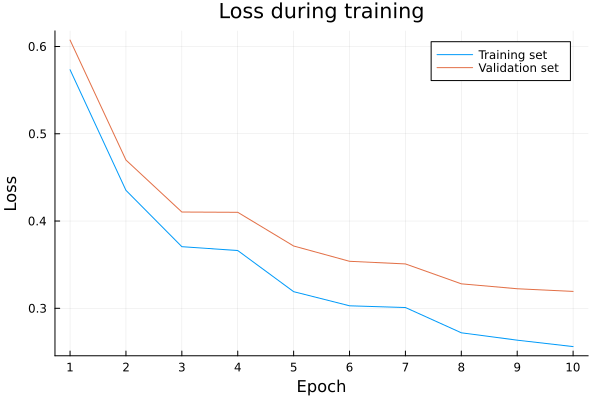

In [11]:
plot([train_losses, val_losses];
    title = "Loss during training",
    label = ["Training set" "Validation set"],
    xguide = "Epoch",
    yguide = "Loss",
    xticks = 1:epochs,
)

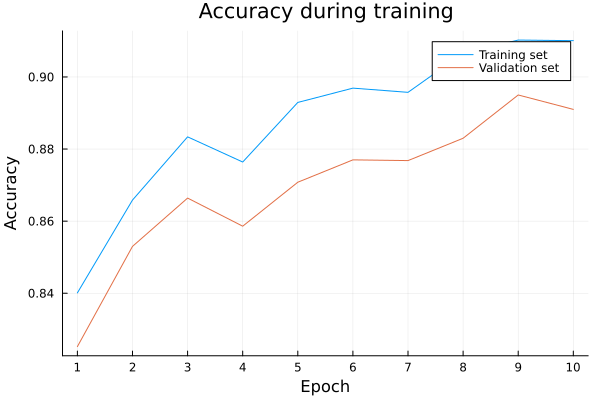

In [12]:
plot([train_accs, val_accs];
    title = "Accuracy during training",
    label = ["Training set" "Validation set"],
    xguide = "Epoch",
    yguide = "Accuracy",
    xticks = 1:epochs,
)

In [17]:
test_acc = accuracy(rn(test_x), test_y)
print("Test accuracy: ", test_acc)

Test accuracy: 0.8846